In [1]:
import itertools
import pandas as pd
import numpy as np
import re
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Model
from scipy import sparse

In [2]:
try:
    texts = pd.read_csv('/kaggle/input/textnlp/TextNLP.csv')
except Exception:
    texts = pd.read_csv('TextNLP.csv')

In [3]:
texts = [x for x in texts['text']]

In [4]:
len(texts)

12

In [5]:
texts

['The future king is the prince',
 'Daughter is the princess ',
 'Son is the prince',
 'Only a man can be a king ',
 'Only a woman can be a queen',
 'The princess will be a queen',
 'Queen and king rule the realm',
 'The prince is a strong man',
 'The princess is a beautiful woman ',
 'The royal family is the king and queen and their children',
 'Prince is only a boy now',
 'A boy will be a man']

In [6]:
def text_preprocessing(TEXT: list, punctuations=r'''!()-[]{};:'"\,<>./?@#$%^&*_“~''', stop_words=None) -> list:
    """
    A method to preprocess a text
    """
    if stop_words is None:
        stop_words = ['and', 'a', 'is', 'the', 'in', 'be', 'will', 'was', 'but', 'this', 'were', 'with', 'of', 'also', 'on', '.', 'for', 'any', 'its', 'and', 'are', 'from', 'both', 'as']
    for x in TEXT.lower():
        if x in punctuations:
            TEXT = TEXT.replace(x, "")

    # Removing words that have numbers in them
    TEXT = re.sub(r'\w*\d\w*', '', TEXT)

    # Removing digits
    TEXT = re.sub(r'[0-9]+', '', TEXT)

    # Cleaning the whitespaces
    TEXT = re.sub(r'\s+', ' ', TEXT).strip()

    # Setting every word to lower
    TEXT = TEXT.lower()

    # Converting all our text to a list 
    TEXT = TEXT.split(' ')

    # Dropping empty strings
    TEXT = [x for x in TEXT if x != '']

    # Dropping stop words
    TEXT = [x for x in TEXT if x not in stop_words]

    return TEXT

In [7]:
# Defining the window for context
window = 2

# Creating a placeholder for the scanning of the word list
word_lists = []
all_text = []
for text in texts:

    # Cleaning the text
    text = text_preprocessing(text)
    # print (text)

    # Appending to the all text lists
    all_text += text

    # Creating a context dictionary
    for i, word in enumerate(text):
        for w in range(window):
            # Getting the context that is ahead by *window* words
            if i + 1 + w < len(text):
                word_lists.append([word] + [text[(i + 1 + w)]])
            # Getting the context that is behind by *window* words
            if i - w - 1 >= 0:
                word_lists.append([word] + [text[(i - w - 1)]])

In [8]:
word_lists

[['future', 'king'],
 ['future', 'prince'],
 ['king', 'prince'],
 ['king', 'future'],
 ['prince', 'king'],
 ['prince', 'future'],
 ['daughter', 'princess'],
 ['princess', 'daughter'],
 ['son', 'prince'],
 ['prince', 'son'],
 ['only', 'man'],
 ['only', 'can'],
 ['man', 'can'],
 ['man', 'only'],
 ['man', 'king'],
 ['can', 'king'],
 ['can', 'man'],
 ['can', 'only'],
 ['king', 'can'],
 ['king', 'man'],
 ['only', 'woman'],
 ['only', 'can'],
 ['woman', 'can'],
 ['woman', 'only'],
 ['woman', 'queen'],
 ['can', 'queen'],
 ['can', 'woman'],
 ['can', 'only'],
 ['queen', 'can'],
 ['queen', 'woman'],
 ['princess', 'queen'],
 ['queen', 'princess'],
 ['queen', 'king'],
 ['queen', 'rule'],
 ['king', 'rule'],
 ['king', 'queen'],
 ['king', 'realm'],
 ['rule', 'realm'],
 ['rule', 'king'],
 ['rule', 'queen'],
 ['realm', 'rule'],
 ['realm', 'king'],
 ['prince', 'strong'],
 ['prince', 'man'],
 ['strong', 'man'],
 ['strong', 'prince'],
 ['man', 'strong'],
 ['man', 'prince'],
 ['princess', 'beautiful'],
 ['p

In [9]:
def create_unique_word_dict(TEXT: list) -> dict:
    """
    A method that creates a dictionary where the keys are unique words
    and key values are indices
    """
    # Getting all the unique words from our text and sorting them alphabetically
    Words = list(set(TEXT))
    Words.sort()

    # Creating the dictionary for the unique words
    UniqueWordDict = {}
    for i, Word in enumerate(Words):
        UniqueWordDict.update({Word: i})

    return UniqueWordDict

In [10]:
unique_word_dict = create_unique_word_dict(all_text)
# Defining the number of features (unique words)
n_words = len(unique_word_dict)
unique_word_dict

{'beautiful': 0,
 'boy': 1,
 'can': 2,
 'children': 3,
 'daughter': 4,
 'family': 5,
 'future': 6,
 'king': 7,
 'man': 8,
 'now': 9,
 'only': 10,
 'prince': 11,
 'princess': 12,
 'queen': 13,
 'realm': 14,
 'royal': 15,
 'rule': 16,
 'son': 17,
 'strong': 18,
 'their': 19,
 'woman': 20}

In [11]:
# Getting all the unique words
words = list(unique_word_dict.keys())
print(words)

['beautiful', 'boy', 'can', 'children', 'daughter', 'family', 'future', 'king', 'man', 'now', 'only', 'prince', 'princess', 'queen', 'realm', 'royal', 'rule', 'son', 'strong', 'their', 'woman']


In [12]:
# Creating the X and Y matrices using one hot encoding
print(n_words)
X = []
Y = []
for i, word_list in tqdm(enumerate(word_lists)):
    # Getting the indices
    print(word_list)
    main_word_index = unique_word_dict.get(word_list[0])
    context_word_index = unique_word_dict.get(word_list[1])
    # print (word_list)
    print(word_list[0], main_word_index)
    print(word_list[1], context_word_index)

    # Creating the placeholders
    X_row = np.zeros(n_words)
    Y_row = np.zeros(n_words)

    # One hot encoding the main word
    X_row[main_word_index] = 1

    # One hot encoding the Y matrix words
    Y_row[context_word_index] = 1

    # Appending to the main matrices
    X.append(X_row)
    Y.append(Y_row)

21


84it [00:00, 23074.30it/s]

['future', 'king']
future 6
king 7
['future', 'prince']
future 6
prince 11
['king', 'prince']
king 7
prince 11
['king', 'future']
king 7
future 6
['prince', 'king']
prince 11
king 7
['prince', 'future']
prince 11
future 6
['daughter', 'princess']
daughter 4
princess 12
['princess', 'daughter']
princess 12
daughter 4
['son', 'prince']
son 17
prince 11
['prince', 'son']
prince 11
son 17
['only', 'man']
only 10
man 8
['only', 'can']
only 10
can 2
['man', 'can']
man 8
can 2
['man', 'only']
man 8
only 10
['man', 'king']
man 8
king 7
['can', 'king']
can 2
king 7
['can', 'man']
can 2
man 8
['can', 'only']
can 2
only 10
['king', 'can']
king 7
can 2
['king', 'man']
king 7
man 8
['only', 'woman']
only 10
woman 20
['only', 'can']
only 10
can 2
['woman', 'can']
woman 20
can 2
['woman', 'only']
woman 20
only 10
['woman', 'queen']
woman 20
queen 13
['can', 'queen']
can 2
queen 13
['can', 'woman']
can 2
woman 20
['can', 'only']
can 2
only 10
['queen', 'can']
queen 13
can 2
['queen', 'woman']
queen 13

# Converting the matrices into a sparse format because the vast majority of the data are 0s

In [13]:
X

[array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
      

In [14]:
Y

[array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
      

In [15]:
XX = tf.convert_to_tensor(X, dtype=tf.float32)
YY = tf.convert_to_tensor(Y, dtype=tf.float32)
print(XX.shape)
print(YY.shape)

(84, 21)
(84, 21)


In [16]:
def CreateModel():
    # Defining the size of the embedding
    embed_size = 2
    # Defining the neural network

    # inp = Input(shape=(X.shape[1],))
    inp = Input(shape=XX.shape[1])  # 21
    x = Dense(units=embed_size, activation='linear')(inp)
    # x = Dense(units=21, activation='softmax')(x)
    x = Dense(units=YY.shape[1], activation='softmax')(x)

    model = Model(inputs=inp, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
    model.summary()
    return model

In [17]:
model = CreateModel()
# Optimizing the network weights
model.fit(
    x=XX,
    y=YY,
    batch_size=64,
    epochs=10000
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense (Dense)               (None, 2)                 44        
                                                                 
 dense_1 (Dense)             (None, 21)                63        
                                                                 
Total params: 107 (428.00 Byte)
Trainable params: 107 (428.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10000
2/2 [==============================] - 1s 12ms/step - loss: 3.0497 - accuracy: 0.0833
Epoch 2/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.0476 - accuracy: 0.0833
Epoch 3/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.0460 - accura

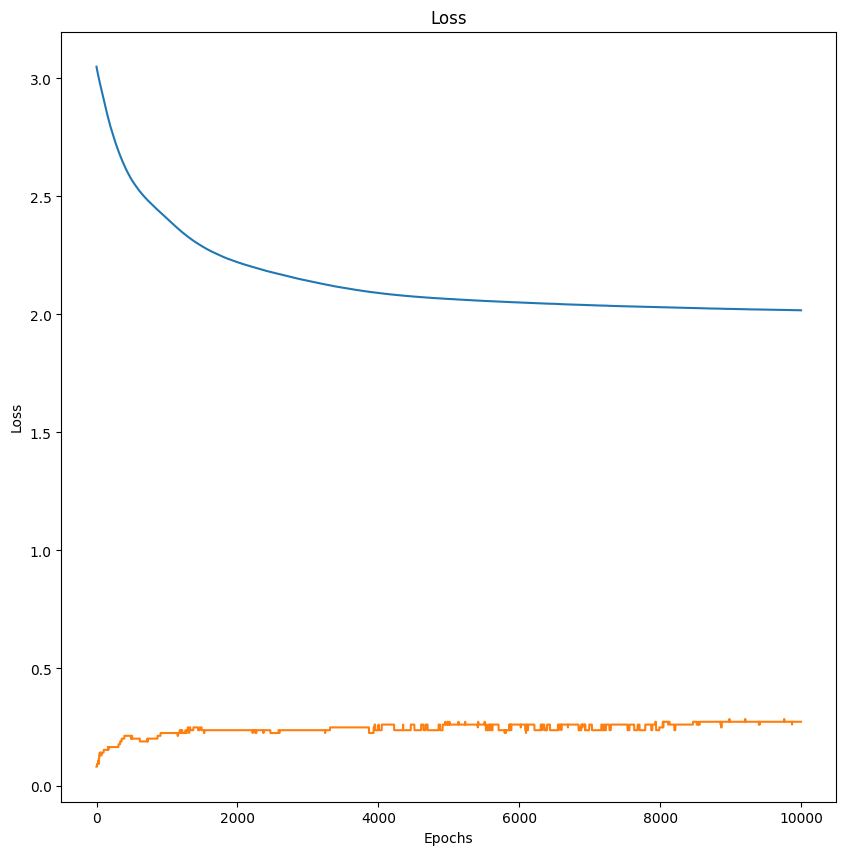

In [18]:
plt.figure(figsize=(10, 10))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['accuracy'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [19]:
# The input layer

weights = model.get_weights()[0]  # 21*2
print(weights.shape)
print(weights[1][1])
print(weights)

# weights = model.get_weights()[2]
# print (weights)

(21, 2)
-3.0579464
[[ -2.2335303    2.6307063 ]
 [ -1.5007008   -3.0579464 ]
 [  0.08293526  -0.2463185 ]
 [ -0.29299325   1.490171  ]
 [ -6.604236     8.541114  ]
 [  0.54030335   0.90349394]
 [  1.653997    -0.37548926]
 [  0.4192314    0.22170615]
 [  0.95635253  -0.43785828]
 [  6.8067274   -6.048984  ]
 [ -1.1467153   -1.0430083 ]
 [  4.141696    -1.4026368 ]
 [ -2.0997982   -0.14777367]
 [  0.01917359   2.838093  ]
 [  2.0356157    4.4226    ]
 [  2.0570893    4.3885126 ]
 [  0.5329073    0.89414173]
 [ -1.2677808  -10.015737  ]
 [ -0.72909844  -7.3469763 ]
 [  0.08190273   3.3107297 ]
 [ -1.2586234   -0.45179868]]


In [20]:
# get the weight for each unique word
embedding_dict = {}
for word in words:  # to pick a row of weight of two values for each unique word since weights = 21*2
    embedding_dict.update({word: weights[unique_word_dict.get(word)]})

In [21]:
embedding_dict

{'beautiful': array([-2.2335303,  2.6307063], dtype=float32),
 'boy': array([-1.5007008, -3.0579464], dtype=float32),
 'can': array([ 0.08293526, -0.2463185 ], dtype=float32),
 'children': array([-0.29299325,  1.490171  ], dtype=float32),
 'daughter': array([-6.604236,  8.541114], dtype=float32),
 'family': array([0.54030335, 0.90349394], dtype=float32),
 'future': array([ 1.653997  , -0.37548926], dtype=float32),
 'king': array([0.4192314 , 0.22170615], dtype=float32),
 'man': array([ 0.95635253, -0.43785828], dtype=float32),
 'now': array([ 6.8067274, -6.048984 ], dtype=float32),
 'only': array([-1.1467153, -1.0430083], dtype=float32),
 'prince': array([ 4.141696 , -1.4026368], dtype=float32),
 'princess': array([-2.0997982 , -0.14777367], dtype=float32),
 'queen': array([0.01917359, 2.838093  ], dtype=float32),
 'realm': array([2.0356157, 4.4226   ], dtype=float32),
 'royal': array([2.0570893, 4.3885126], dtype=float32),
 'rule': array([0.5329073 , 0.89414173], dtype=float32),
 'son

0  >>  beautiful
1  >>  boy
2  >>  can
3  >>  children
4  >>  daughter
5  >>  family
6  >>  future
7  >>  king
8  >>  man
9  >>  now
10  >>  only
11  >>  prince
12  >>  princess
13  >>  queen
14  >>  realm
15  >>  royal
16  >>  rule
17  >>  son
18  >>  strong
19  >>  their
20  >>  woman


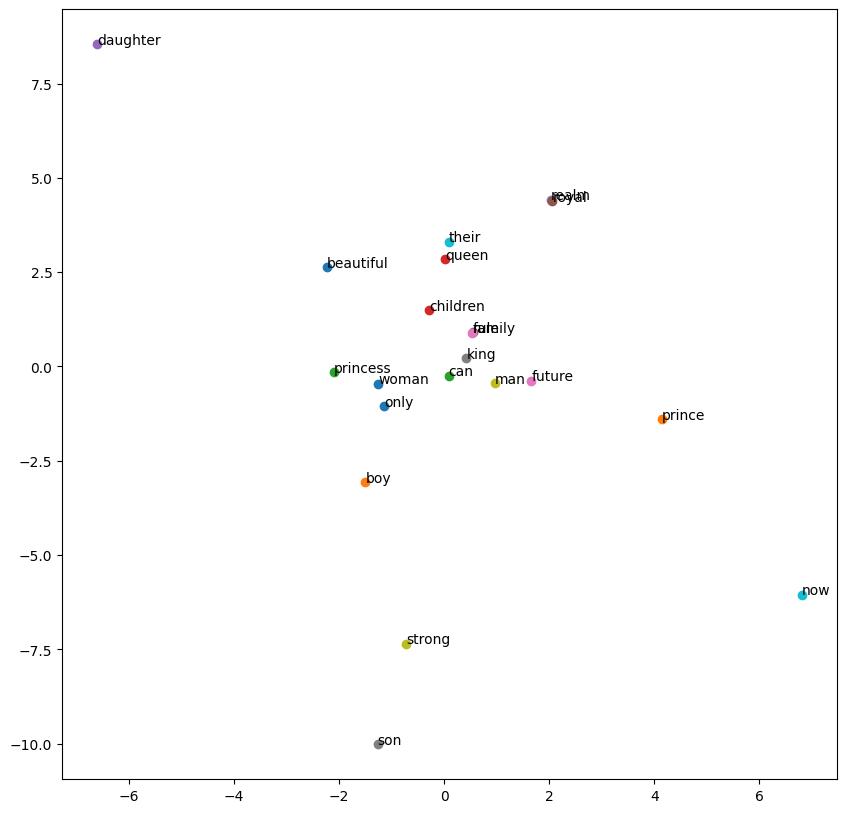

In [22]:
plt.figure(figsize=(10, 10))
i = 0
for word in list(unique_word_dict.keys()):
    print(i, ' >> ', word)
    coord = embedding_dict.get(word)
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1]))
    i = i + 1

In [23]:
# The input layer
weights = model.get_weights()[0]
# weights[: , 0] = 0

0  >>  beautiful
1  >>  boy
2  >>  can
3  >>  children
4  >>  daughter
5  >>  family
6  >>  future
7  >>  king
8  >>  man
9  >>  now
10  >>  only
11  >>  prince
12  >>  princess
13  >>  queen
14  >>  realm
15  >>  royal
16  >>  rule
17  >>  son
18  >>  strong
19  >>  their
20  >>  woman


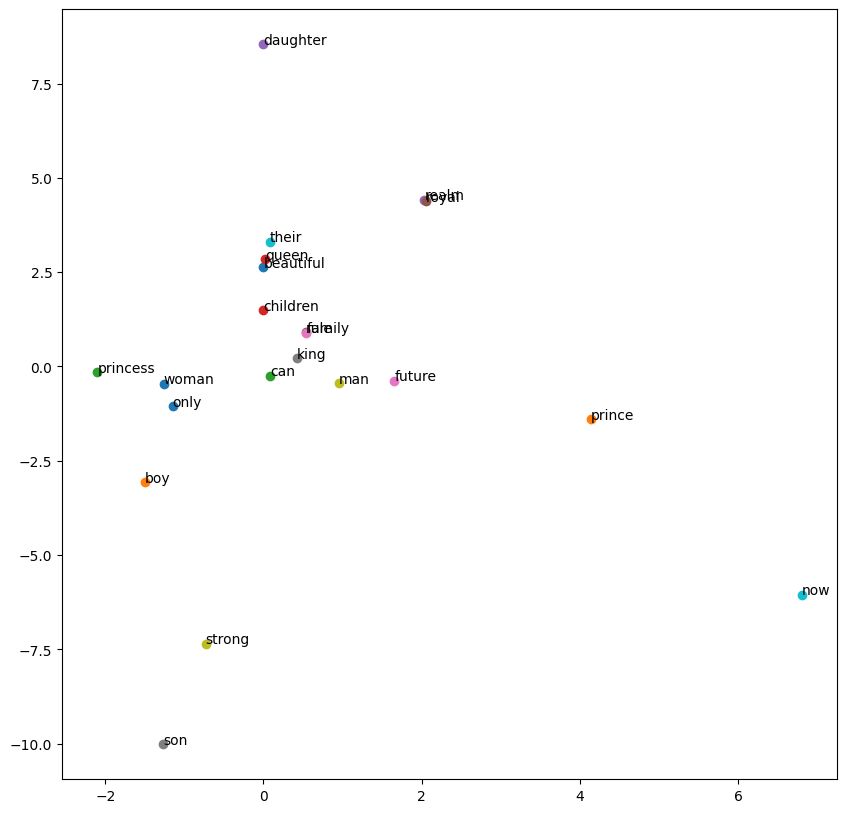

In [24]:
plt.figure(figsize=(10, 10))
i = 0
for word in list(unique_word_dict.keys()):
    print(i, ' >> ', word)
    # coord = embedding_dict.get(word)
    coord = embedding_dict.get(word)
    if weights[i][0] < 0 < weights[i][1]:
        plt.scatter(0, weights[i][1])
        plt.annotate(word, (0, weights[i][1]))
    else:
        plt.scatter(weights[i][0], weights[i][1])
        plt.annotate(word, (weights[i][0], weights[i][1]))
    i = i + 1